In [2]:
from datasets import load_dataset
ds = load_dataset("garage-bAInd/Open-Platypus", split='train')

README.md:   0%|          | 0.00/5.34k [00:00<?, ?B/s]

(…)-00000-of-00001-4fe2df04669d1669.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/24926 [00:00<?, ? examples/s]

In [6]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib einops

In [8]:
train_val_split = ds.train_test_split(test_size=0.2)

# Extract the training and validation datasets
train_dataset = train_val_split['train']
val_dataset = train_val_split['test']

# Print the size of the datasets
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

Training set size: 19940
Validation set size: 4986


In [9]:
print(ds[0])

{'input': '', 'output': 'To find the probability of the spinner landing on $C$, I need to subtract the probabilities of the spinner landing on $A$ and $B$ from $1$, since the sum of the probabilities of all possible outcomes is $1$. I can write this as an equation: $P(C) = 1 - P(A) - P(B)$. I know that $P(A) = \\frac{1}{3}$ and $P(B) = \\frac{5}{12}$, so I can plug those values into the equation and simplify. I get: $P(C) = 1 - \\frac{1}{3} - \\frac{5}{12} = \\frac{12}{12} - \\frac{4}{12} - \\frac{5}{12} = \\frac{3}{12}$. I can reduce this fraction by dividing the numerator and denominator by $3$, and I get: $P(C) = \\frac{1}{4}$. ', 'instruction': 'A board game spinner is divided into three parts labeled $A$, $B$  and $C$. The probability of the spinner landing on $A$ is $\\frac{1}{3}$ and the probability of the spinner landing on $B$ is $\\frac{5}{12}$.  What is the probability of the spinner landing on $C$? Express your answer as a common fraction.', 'data_source': 'MATH/PRM-800K'}


In [10]:
def formatting_func(example):
    text = f"### Question: {example['instruction']}\n ### Answer: {example['output']}"
    return text

In [11]:
print(formatting_func(ds[0]))

### Question: A board game spinner is divided into three parts labeled $A$, $B$  and $C$. The probability of the spinner landing on $A$ is $\frac{1}{3}$ and the probability of the spinner landing on $B$ is $\frac{5}{12}$.  What is the probability of the spinner landing on $C$? Express your answer as a common fraction.
 ### Answer: To find the probability of the spinner landing on $C$, I need to subtract the probabilities of the spinner landing on $A$ and $B$ from $1$, since the sum of the probabilities of all possible outcomes is $1$. I can write this as an equation: $P(C) = 1 - P(A) - P(B)$. I know that $P(A) = \frac{1}{3}$ and $P(B) = \frac{5}{12}$, so I can plug those values into the equation and simplify. I get: $P(C) = 1 - \frac{1}{3} - \frac{5}{12} = \frac{12}{12} - \frac{4}{12} - \frac{5}{12} = \frac{3}{12}$. I can reduce this fraction by dividing the numerator and denominator by $3$, and I get: $P(C) = \frac{1}{4}$. 


In [12]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from peft import LoraConfig, get_peft_model

In [13]:
base_model_id = "microsoft/phi-2"
model = AutoModelForCausalLM.from_pretrained(base_model_id, trust_remote_code=True, torch_dtype=torch.float16, load_in_8bit=True)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
!pip install -q wandb -U


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [15]:
import wandb, os
wandb.login()

wandb_project = "journal-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/ubuntu/.netrc


In [16]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
    use_fast=False, # needed for now, should be fixed soon
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

In [17]:
# tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
# tokenized_val_dataset = val_dataset.map(generate_and_tokenize_prompt)

In [18]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

# plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [19]:
max_length = 2048 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [20]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = val_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/19940 [00:00<?, ? examples/s]

Map:   0%|          | 0/4986 [00:00<?, ? examples/s]

In [16]:
# print(tokenized_train_dataset[1]['input_ids'])

24926


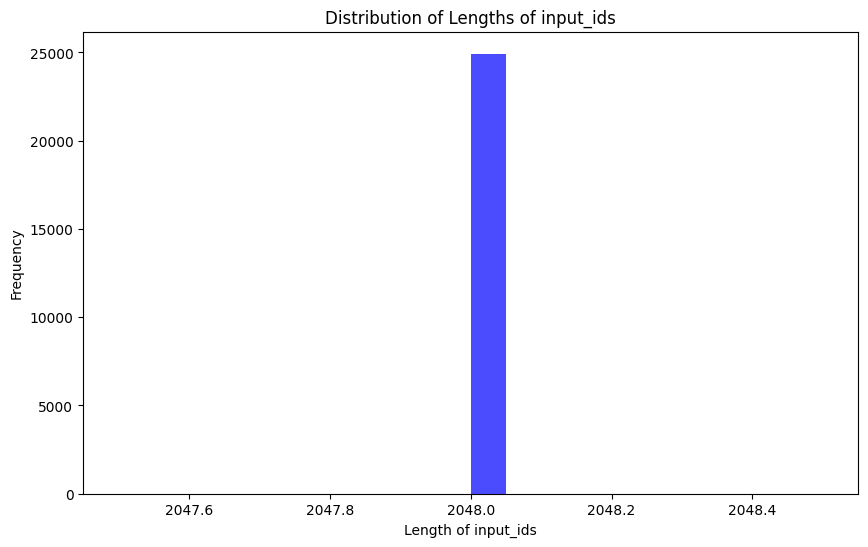

In [21]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [22]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [23]:
print(model)

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiSdpaAttention(
          (q_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (dense): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear8bitLt(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear8bitLt(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
 

In [24]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "Wqkv",
        "fc1",
        "fc2",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 26214400 || all params: 2805898240 || trainable%: 0.9342605382581515


In [25]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PhiForCausalLM(
      (model): PhiModel(
        (embed_tokens): Embedding(51200, 2560)
        (embed_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-31): 32 x PhiDecoderLayer(
            (self_attn): PhiSdpaAttention(
              (q_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (k_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (v_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (dense): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (rotary_emb): PhiRotaryEmbedding()
            )
            (mlp): PhiMLP(
              (activation_fn): NewGELUActivation()
              (fc1): lora.Linear8bitLt(
                (base_layer): Linear8bitLt(in_features=2560, out_features=10240, bias=True)
                (lora_dropout): ModuleDict(
                  (default

In [22]:
# !pip install -q -U bitsandbytes
# !pip install -q -U git+https://github.com/huggingface/transformers.git
# !pip install -q -U git+https://github.com/huggingface/peft.git
# !pip install -q -U git+https://github.com/huggingface/accelerate.git
# !pip install -q -U datasets scipy ipywidgets matplotlib einops

In [26]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [1]:
import transformers
from datetime import datetime

project = "phi2-finetune"
base_model_name = "phi2"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

NameError: name 'model' is not defined